In [1]:
import numpy
from scipy.stats import norm
numpy.seterr(all='ignore')

def pdf(x,mu,sigma): #normal distribution pdf
    x = (x-mu)/sigma
    return numpy.exp(-x**2/2)/(numpy.sqrt(2*numpy.pi)*sigma)

def invLogCDF(x,mu,sigma): #normal distribution cdf
    x = (x - mu) / sigma
    return norm.logcdf(-x) #note: we mutiple by -1 after normalization to better get the 1-cdf

def sigmoid(x):
    return 1. / (1 + numpy.exp(-x))


def dsigmoid(x):
    return x * (1. - x)

def tanh(x):
    return numpy.tanh(x)

def dtanh(x):
    return 1. - x * x

def softmax(x):
    e = numpy.exp(x - numpy.max(x))  # prevent overflow
    if e.ndim == 1:
        return e / numpy.sum(e, axis=0)
    else:
        return e / numpy.array([numpy.sum(e, axis=1)]).T  # ndim = 2


def ReLU(x):
    return x * (x > 0)

def dReLU(x):
    return 1. * (x > 0)

class rollmean:
    def __init__(self,k):
        self.winsize = k
        self.window = numpy.zeros(self.winsize)
        self.pointer = 0

    def apply(self,newval):
        self.window[self.pointer]=newval
        self.pointer = (self.pointer+1) % self.winsize
        return numpy.mean(self.window)


In [2]:
import sys
import numpy
import json

class dA_params:
    def __init__(self,n_visible = 5, n_hidden = 3, lr=0.01, corruption_level=0.0, gracePeriod = 10000, hiddenRatio=None):
        self.n_visible = n_visible# num of units in visible (input) layer
        self.n_hidden = n_hidden# num of units in hidden layer
        self.lr = lr
        self.corruption_level = corruption_level
        self.gracePeriod = gracePeriod
        self.hiddenRatio = hiddenRatio

class dA:
    def __init__(self, params):
        self.params = params

        if self.params.hiddenRatio is not None:
            self.params.n_hidden = int(numpy.ceil(self.params.n_visible*self.params.hiddenRatio))

        # for 0-1 normlaization
        self.norm_max = numpy.ones((self.params.n_visible,)) * -numpy.Inf
        self.norm_min = numpy.ones((self.params.n_visible,)) * numpy.Inf
        self.n = 0

        self.rng = numpy.random.RandomState(1234)

        a = 1. / self.params.n_visible
        self.W = numpy.array(self.rng.uniform(  # initialize W uniformly
            low=-a,
            high=a,
            size=(self.params.n_visible, self.params.n_hidden)))

        self.hbias = numpy.zeros(self.params.n_hidden)  # initialize h bias 0
        self.vbias = numpy.zeros(self.params.n_visible)  # initialize v bias 0
        self.W_prime = self.W.T


    def get_corrupted_input(self, input, corruption_level):
        assert corruption_level < 1

        return self.rng.binomial(size=input.shape,
                                 n=1,
                                 p=1 - corruption_level) * input

    # Encode
    def get_hidden_values(self, input):
        return sigmoid(numpy.dot(input, self.W) + self.hbias)

    # Decode
    def get_reconstructed_input(self, hidden):
        return sigmoid(numpy.dot(hidden, self.W_prime) + self.vbias)

    def train(self, x):
        self.n = self.n + 1
        # update norms
        self.norm_max[x > self.norm_max] = x[x > self.norm_max]
        self.norm_min[x < self.norm_min] = x[x < self.norm_min]

        # 0-1 normalize
        x = (x - self.norm_min) / (self.norm_max - self.norm_min + 0.0000000000000001)

        if self.params.corruption_level > 0.0:
            tilde_x = self.get_corrupted_input(x, self.params.corruption_level)
        else:
            tilde_x = x
        y = self.get_hidden_values(tilde_x)
        z = self.get_reconstructed_input(y)

        L_h2 = x - z
        L_h1 = numpy.dot(L_h2, self.W) * y * (1 - y)

        L_vbias = L_h2
        L_hbias = L_h1
        L_W = numpy.outer(tilde_x.T, L_h1) + numpy.outer(L_h2.T, y)

        self.W += self.params.lr * L_W
        self.hbias += self.params.lr * numpy.mean(L_hbias, axis=0)
        self.vbias += self.params.lr * numpy.mean(L_vbias, axis=0)
        return numpy.sqrt(numpy.mean(L_h2**2)) #the RMSE reconstruction error during training


    def reconstruct(self, x):
        y = self.get_hidden_values(x)
        z = self.get_reconstructed_input(y)
        return z

    def execute(self, x): #returns MSE of the reconstruction of x
        if self.n < self.params.gracePeriod:
            return 0.0
        else:
            # 0-1 normalize
            x = (x - self.norm_min) / (self.norm_max - self.norm_min + 0.0000000000000001)
            z = self.reconstruct(x)
            rmse = numpy.sqrt(((x - z) ** 2).mean()) #MSE
            return rmse

    def inGrace(self):
        return self.n < self.params.gracePeriod


In [3]:
#Feature Grouping
from sklearn.cluster import AffinityPropagation
import numpy as np
import time


def cluster(A):
    start = time.time()
    A = A.T
    A = np.mean(A,axis=1)#The Average Value of Features
    clustering = AffinityPropagation(max_iter=1000).fit(A.reshape(-1,1))#max_iter=300
    labels = list(clustering.labels_)
    size1 = list(set(labels))
    Map = []
    Value = []
    for size in size1:
        index = []
        value = []
        for i in range(len(labels)):
            if labels[i] == size:
                index.append(i)
                value.append(A[i])
        Map.append(index)
        Value.append(value)
    stop = time.time()
    print("CompleteTime: "+ str(stop - start))
    print(Map)
    for v in Value:
        print(v)
    return Map





In [4]:
import numpy as np

# This class represents a KitNET machine learner.
# KitNET is a lightweight online anomaly detection algorithm based on an ensemble of autoencoders.
# For more information and citation, please see our NDSS'18 paper: Kitsune: An Ensemble of Autoencoders for Online Network Intrusion Detection
# For licensing information, see the end of this document

class KitNET:
    #n: the number of features in your input dataset (i.e., x \in R^n)
    #AD_grace_period: the number of instances the network will learn from before producing anomaly scores
    #FM_grace_period: the number of instances which will be taken to learn the feature mapping. If 'None', then FM_grace_period=AM_grace_period
    #learning_rate: the default stochastic gradient descent learning rate for all autoencoders in the KitNET instance.
    #hidden_ratio: the default ratio of hidden to visible neurons. E.g., 0.75 will cause roughly a 25% compression in the hidden layer.
    #feature_map: One may optionally provide a feature map instead of learning one. The map must be a list,
    #           where the i-th entry contains a list of the feature indices to be assingned to the i-th autoencoder in the ensemble.
    #           For example, [[2,5,3],[4,0,1],[6,7]]
    def __init__(self,n,FM_grace_period=None,AD_grace_period=10000,learning_rate=0.1,hidden_ratio=0.75, feature_map = None):
        # Parameters:
        self.AD_grace_period = AD_grace_period
        if FM_grace_period is None:
            self.FM_grace_period = AD_grace_period
        else:
            self.FM_grace_period = FM_grace_period
        self.lr = learning_rate
        self.hr = hidden_ratio
        self.n = n
        # Variables
        self.n_trained = 0 # the number of training instances so far
        self.n_executed = 0 # the number of executed instances so far
        self.v = feature_map
        if self.v is None:
            print("Feature-Mapper: train-mode, Anomaly-Detector: off-mode")
        else:
            self.__createAD__()
            print("Feature-Mapper: execute-mode, Anomaly-Detector: train-mode")
        #self.FM = CC.corClust(self.n) #incremental feature cluatering for the feature mapping process
        self.ensembleLayer = []
        self.outputLayer = None

    #If FM_grace_period+AM_grace_period has passed, then this function executes KitNET on x. Otherwise, this function learns from x.
    #x: a numpy array of length n
    #Note: KitNET automatically performs 0-1 normalization on all attributes.
    def process(self,x,X):
        if self.n_trained > self.FM_grace_period + self.AD_grace_period: #If both the FM and AD are in execute-mode
            return self.execute(x)
        else:
            self.train(x,X)
            return 0.0

    #force train KitNET on x
    #returns the anomaly score of x during training (do not use for alerting)
    def train(self,x,X):

# 85%*25% of normal samples are extracted and the average values of each feature are calculated to get the samples to be clustered.
        if self.n_trained == self.FM_grace_period: #If the feature mapping should be instantiated
            self.v = cluster(X[0:self.FM_grace_period-1])
            self.__createAD__()
            print("The Feature-Mapper found a mapping: "+str(self.n)+" features to "+str(len(self.v))+" autoencoders.")
            print("Feature-Mapper: execute-mode, Anomaly-Detector: train-mode")
        elif self.n_trained > self.FM_grace_period and self.n_trained <= self.AD_grace_period+self.FM_grace_period: #train
            ## Ensemble Layer
            S_l1 = np.zeros(len(self.ensembleLayer))
            for a in range(len(self.ensembleLayer)):
                # make sub instance for autoencoder 'a'
                xi = x[self.v[a]]
                S_l1[a] = self.ensembleLayer[a].train(xi)
            ## OutputLayer
            self.outputLayer.train(S_l1) # or self.outputLayer = np.mean(S_l1)
            if self.n_trained == self.AD_grace_period+self.FM_grace_period:
                print("Feature-Mapper: execute-mode, Anomaly-Detector: exeute-mode")
        self.n_trained += 1

    #force execute KitNET on x
    def execute(self,x):
        if self.v is None:
            raise RuntimeError('KitNET Cannot execute x, because a feature mapping has not yet been learned or provided. Try running process(x) instead.')
        else:
            self.n_executed += 1
            ## Ensemble Layer
            S_l1 = np.zeros(len(self.ensembleLayer))
            for a in range(len(self.ensembleLayer)):
                # make sub inst
                xi = x[self.v[a]]
                S_l1[a] = self.ensembleLayer[a].execute(xi)
            ## OutputLayer
            return self.outputLayer.execute(S_l1) #or return np.mean(S_l1)

    def __createAD__(self):
        # construct ensemble layer
        for map in self.v:
            params = dA_params(n_visible=len(map), n_hidden=0, lr=self.lr, corruption_level=0, gracePeriod=0, hiddenRatio=self.hr)
            self.ensembleLayer.append(dA(params))

        # construct output layer
        params = dA_params(len(self.v), n_hidden=0, lr=self.lr, corruption_level=0, gracePeriod=0, hiddenRatio=self.hr)
        self.outputLayer = dA(params)

 # Copyright (c) 2017 Yisroel Mirsky


{'Brute Force -Web', 'SQL Injection', 'Benign', 'Brute Force -XSS'}
SQL Injection
1048062
Feature ranking:
1. feature 66 (0.203242)
2. feature 11 (0.056663)
3. feature 0 (0.054944)
4. feature 14 (0.048059)
5. feature 46 (0.042838)
6. feature 51 (0.042548)
7. feature 40 (0.038935)
8. feature 37 (0.029492)
9. feature 43 (0.026072)
10. feature 16 (0.024594)
11. feature 67 (0.022865)
12. feature 42 (0.021566)
13. feature 19 (0.019522)
14. feature 24 (0.017741)
15. feature 22 (0.017707)
16. feature 17 (0.016941)
17. feature 21 (0.016516)
18. feature 2 (0.015607)
19. feature 18 (0.015506)
20. feature 55 (0.015031)
21. feature 13 (0.014247)
22. feature 25 (0.013593)
Counter({0: 1048009, 1: 53})
1048062
Feature-Mapper: train-mode, Anomaly-Detector: off-mode
Running KitNET:
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
CompleteTime: 0.014006376266479492
[[1], [5, 8, 9], [0, 7, 10, 12, 16], [6, 1

d:\anaconda3\envs\tf1\lib\site-packages\sklearn\cluster\_affinity_propagation.py:154: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 1.0 (renaming of 0.25) which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  FutureWarning


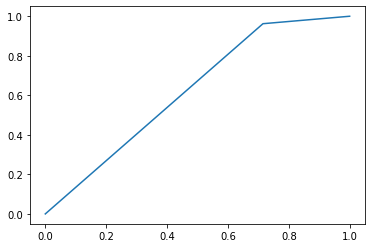

In [21]:
# -*- coding: utf-8 -*-
"""
Created on Sun Feb  9 16:05:06 2020

@author: Mr.L
"""

import numpy as np
import pandas as pd
import time
X = pd.read_csv('SQL Injection.csv',low_memory=False)
l = set(X["Label"])
print(l)
print("SQL Injection")
A = X[(X["Label"]=='Benign')]
B = X[(X["Label"]=='SQL Injection')]
X = pd.concat([A,B],axis=0,ignore_index=True)
print(len(X))

X = X.replace("Infinity",0)
X = X.replace(np.NaN,0)
X = X.drop(["Timestamp"], axis=1)
X = X.replace("Benign",0)
X = X.replace("SQL Injection",1)
X = X.sort_values(["Label"],ascending=True)

Label = np.array(X["Label"])
y_test = Label
y_test=np.nan_to_num(y_test)
X = X.drop(["Label"], axis=1)
X = X.astype(float)
X = np.array(X)
inf_loc=np.isinf(X)
X[inf_loc]=0
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
clf = ExtraTreesClassifier(n_estimators=3000,n_jobs=-1)#,bootstrap=True,oob_score=True)#
clf = clf.fit(X, y_test)#,max_depth=20
#print(clf.oob_score_)
model = SelectFromModel(clf, prefit=True)
X = model.transform(X)
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],axis=0)
indices = np.argsort(importances)[::-1]
# Print the feature ranking
importanceindex = []
print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))


from collections import Counter
z = Counter(Label)
print(z)
print(len(X))

from sklearn.preprocessing import Normalizer
norm1 = Normalizer(norm='l2')
X = norm1.fit_transform(X)

#KitNET params:
Ratio = 0.85
FMgrace = int(np.trunc(z[0]*Ratio*0.25))#the number of instances taken to learn the feature mapping (the ensemble's architecture)
ADgrace = int(np.trunc(z[0]*Ratio*0.75))#the number of instances used to train the anomaly detector (ensemble itself)
# Build KitNET
K = KitNET(X.shape[1],FMgrace,ADgrace)
RMSEs = np.zeros(X.shape[0]) # a place to save the scores
#S = np.zeros(X.shape[0])
print("Running KitNET:")

start = time.time()
for i in range(X.shape[0]):
    if i % 10000 == 0:
        print(i)
    RMSEs[i] = K.process(X[i,],X) #will train during the grace periods, then execute on all the rest.
stop = time.time()
print("Complete. Time elapsed: "+ str(stop - start))

X_train = RMSEs[FMgrace+ADgrace+1:].reshape(-1,1)
y_test1 = y_test[FMgrace+ADgrace+1:]
#
#from sklearn.mixture import GaussianMixture
#gmm = GaussianMixture(n_components=2).fit(X_train)
#y_pred = gmm.predict(X_train)

from sklearn.cluster import KMeans
clf = KMeans(n_clusters=2)
clf.fit(X_train)
y_pred = clf.labels_
###
#
for i in range(len(y_pred)):
    if y_pred[i]==0:
        y_pred[i]=1
    else:
        y_pred[i]=0

from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test1, y_pred)
print("accuracy_score",acc)
from sklearn.metrics import precision_score
pre = precision_score(y_test1, y_pred)
print("precision_score",pre)
from sklearn.metrics import recall_score
rec = recall_score(y_test1, y_pred)
print("recall_score",rec)
from sklearn.metrics import f1_score
print("f1_score",f1_score(y_test1, y_pred))
#
from sklearn.metrics import roc_curve
FTP,TPR,threshold = roc_curve(y_test1,y_pred)
print("ROC_AUC Score")
import matplotlib.pyplot as plt
plt.plot(FTP,TPR)
plt.show()
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_test1,y_pred))

from sklearn.metrics import confusion_matrix
print("confusion matrix")
print(confusion_matrix(y_test1,y_pred))

{'Bot', 'Benign'}
1048575
{'Bot', 'Benign'}
Sparse Fwd<=1
Counter({0: 194892, 1: 144008})
338900
0.9999616406019475
Feature ranking:
1. feature 0 (0.318881)
2. feature 66 (0.078054)
3. feature 37 (0.066224)
4. feature 16 (0.065986)
5. feature 49 (0.045571)
6. feature 48 (0.041785)
7. feature 21 (0.033826)
8. feature 2 (0.033296)
9. feature 25 (0.032904)
10. feature 24 (0.032358)
11. feature 22 (0.032026)
12. feature 19 (0.030957)
13. feature 17 (0.029972)
14. feature 20 (0.029681)
15. feature 47 (0.026469)
Counter({0: 194892, 1: 144008})
Feature-Mapper: train-mode, Anomaly-Detector: off-mode
Running KitNET:
0
10000
20000
30000
40000
CompleteTime: 0.003998994827270508
[[3, 5, 7, 9], [0, 1, 4, 6, 8], [2, 10], [11, 12, 13, 14]]
[0.13442523307606144, 0.11117444954722515, 0.13392666907588838, 0.10962517531496006]
[0.19759303943839984, 0.2026689280072335, 0.17540851074853295, 0.18498170435670988, 0.16038724713835412]
[0.3323494107291225, 0.2723967232355435]
[2.488513443746137e-07, 1.49233581

d:\anaconda3\envs\tf1\lib\site-packages\sklearn\cluster\_affinity_propagation.py:154: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 1.0 (renaming of 0.25) which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  FutureWarning


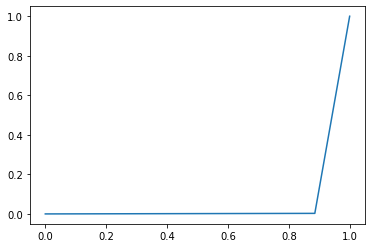

In [23]:
# -*- coding: utf-8 -*-
"""
Created on Thu Mar  7 13:09:11 2019
@author: Mr.L
0"""
import numpy as np
import pandas as pd
import time
X = pd.read_csv('Bot.csv',low_memory=False)
l = set(X["Label"])
print(l)

A = X[(X["Label"]=='Benign')]
B = X[(X["Label"]=='Bot')]

X = pd.concat([A,B],axis=0,ignore_index=True)
print(len(X))
l = set(X["Label"])
print(l)
print("Sparse Fwd<=1")
X = X[(X["TotLen Fwd Pkts"]<=1)]#SparseMatrix{Bot}
#print("Sparse Fwd>1")
#X = X[(X["TotLen Fwd Pkts"]>1)]#DenseMatrix{Bot}
##
#print("Sparse Bwd==0")
#X = X[(X["TotLen Bwd Pkts"]==0)]#SparseMatrix{DDOS:HOIC}
#print("Sparse Bwd!=0")
#X = X[(X["TotLen Bwd Pkts"]!=0)]#DenseMatrix{DDOS:HOIC}
#
#print("Sparse Fwd==0")
#X = X[(X["TotLen Fwd Pkts"]==0)]#SparseMatrix{DDOS:LOIC-UDP}0.2
#print("Sparse Fwd!=0")
#X = X[(X["TotLen Fwd Pkts"]!=0)]#SparseMatrix{DoS:LOIC-UDP}

#print("Sparse Fwd==0")
#X = X[(X["TotLen Fwd Pkts"]==0)]#SparseMatrix{Brute Force -XSS}0.4
#print("Sparse Fwd!=0")
#X = X[(X["TotLen Fwd Pkts"]!=0)]#SparseMatrix{Brute Force -XSS}0.4

#print("Sparse Fwd=0")
#X = X[(X["TotLen Fwd Pkts"]==0)]#SparseMatrix{Brute Force -Web}0.4
#print("Sparse Fwd!=0")
#X = X[(X["TotLen Fwd Pkts"]!=0)]#SparseMatrix{Brute Force -Web}0.4

#print("Sparse Bwd==0")
#X = X[(X["TotLen Bwd Pkts"]==0)]#SparseMatrix{SQL Injection}
#print("Sparse Bwd!=0")
#X = X[(X["TotLen Bwd Pkts"]!=0)]#DenseMatrix{SQL Injection}

#print("Sparse Fwd==0")
#X = X[(X["TotLen Fwd Pkts"]==0)]#SparseMatrix{Infilteration}
#print("Sparse Fwd!=0")
#X = X[(X["TotLen Fwd Pkts"]!=0)]#SparseMatrix{Infilteration}

#print("Sparse Bwd==0")
#X = X[(X["TotLen Bwd Pkts"]==0)]#SparseMatrix{FTP-BruteForce}
#print("Sparse Bwd!=0")
#X = X[(X["TotLen Bwd Pkts"]!=0)]#DenseMatrix{FTP-BruteForce}

#print("Sparse Bwd==0")
#X = X[(X["TotLen Bwd Pkts"]==0)]#SparseMatrix{SSH-Bruteforce}
#print("Sparse Bwd!=0")
#X = X[(X["TotLen Bwd Pkts"]!=0)]#DenseMatrix{SSH-Bruteforce}

#Data Preprocessing
X = X.replace("Infinity",0)
X = X.replace(np.NaN,0)
X = X.drop(["Timestamp"], axis=1)
X = X.replace("Benign",0)
X = X.replace("Bot",1)
X = X.sort_values(["Label"],ascending=True)

Label = np.array(X["Label"])
y_test = Label
X = X.drop(["Label"], axis=1)
X = X.astype(float)
X = np.array(X)
inf_loc=np.isinf(X)
X[inf_loc]=0
#Statistics
from collections import Counter
z = Counter(Label)
print(z)
print(len(X))

#up-sample
#if len(z)!=1:
#    if z[1]<int(np.trunc(len(X)*0.1)):
#        from imblearn.over_sampling import RandomOverSampler
#        ros = RandomOverSampler(random_state=0)
#        X1, Label1 = ros.fit_sample(X[int(np.trunc(z[0]*0.85)):], Label[int(np.trunc(z[0]*0.85)):])
#        X = np.vstack((X[0:int(np.trunc(z[0]*0.85))],X1))
#        y_test = np.hstack((Label[0:int(np.trunc(z[0]*0.85))],Label1))

#Feature Selection
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
clf = ExtraTreesClassifier(n_estimators=1000,n_jobs=-1,bootstrap=True,oob_score=True)#
clf = clf.fit(X, y_test)#,max_depth=20
print(clf.oob_score_)
model = SelectFromModel(clf, prefit=True)
X = model.transform(X)

importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],axis=0)
indices = np.argsort(importances)[::-1]
# Print the feature ranking
importanceindex = []
print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))


from collections import Counter
z1 = Counter(y_test)
print(z1)

#L2 Regularization
from sklearn.preprocessing import Normalizer
norm1 = Normalizer(norm='l2')
X = norm1.fit_transform(X)

#KitNET params:
Ratio = 0.85
FMgrace = int(np.trunc(z1[0]*Ratio*0.25))#the number of instances taken to learn the feature Grouping (the ensemble's architecture)
ADgrace = int(np.trunc(z1[0]*Ratio*0.75))#the number of instances used to train the anomaly detector (ensemble itself)
# Build KitNET
K = KitNET(X.shape[1],FMgrace,ADgrace)
RMSEs = np.zeros(X.shape[0]) # a place to save the scores
#S = np.zeros(X.shape[0])
print("Running KitNET:")

start = time.time()
for i in range(X.shape[0]):
    if i % 10000 == 0:
        print(i)
    RMSEs[i] = K.process(X[i,],X) #will train during the grace periods, then execute on all the rest.
stop = time.time()
print("Complete. Time elapsed: "+ str(stop - start))

X_train = RMSEs[FMgrace+ADgrace+1:].reshape(-1,1)
y_test1 = y_test[FMgrace+ADgrace+1:]

#GMM
#from sklearn.mixture import GaussianMixture
#gmm = GaussianMixture(n_components=2).fit(X_train)
#y_pred = gmm.predict(X_train)

#K-means
from sklearn.cluster import KMeans
clf = KMeans(n_clusters=2)
clf.fit(X_train)
y_pred = clf.labels_

#for i in range(len(y_pred)):
#    if y_pred[i]==0:
#        y_pred[i]=1
#    else:
#        y_pred[i]=0

#Accuracy,Precision,Recall,F1
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test1, y_pred)
print("accuracy_score",acc)
from sklearn.metrics import precision_score
pre = precision_score(y_test1, y_pred)
print("precision_score",pre)
from sklearn.metrics import recall_score
rec = recall_score(y_test1, y_pred)
print("recall_score",rec)
from sklearn.metrics import f1_score
print("f1_score",f1_score(y_test1, y_pred))

#ROC_AUC
from sklearn.metrics import roc_curve
FTP,TPR,threshold = roc_curve(y_test1,y_pred)
print("ROC_AUC Score")
import matplotlib.pyplot as plt
plt.plot(FTP,TPR)
plt.show()
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_test1,y_pred))

#Confusion_matrix
from sklearn.metrics import confusion_matrix
print("confusion matrix")
print(confusion_matrix(y_test1,y_pred))
